# DDPG 

This notebook contains an implementation of Deep Deterministic Policy Gradients (DDPG) which is a model-free reinforcement learning algorithm designed for continuous action spaces, utilizing an actor-critic architecture. 
In the following DDPG is used to safely land a lunarlander from [Gymnasium environments](https://gymnasium.farama.org/environments/box2d/lunar_lander/).

<img src="./resources/lunar_lander.gif" alt="Gymnasium" width="20%"/>

## Packages

In [46]:
!pip install pandas
!pip install torch
!pip install swig
!pip install gymnasium
!pip install "gymnasium[box2d]"
!pip install matplotlib
!pip install imageio

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [47]:
from typing import Iterable
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

## Theory
Remember that for Q-learning, we have the following update:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma \max_{a'}Q(s', a') - Q(s, a))$

with discount factor $\gamma$, learning rate $\alpha$, reward $r$, sampled state $s$, sampled next state $s'$ and sampled action $a$. The $\max$ operator enumerates through the finite number of discrete actions and chooses the action correcponding to the maximum $Q(s', a')$. The $\max$ operator essentially represents the greedy policy for a discrete case. 

In continuous action settings there are infinite many actions and hence we need a new strategy for selecting actions. This is where the Actor network, $\mu(s)$ comes into play. The actor is the explicit representation of the action selection strategy (or policy). It takes in a state $s$ as input and outputs an action $a$ which it believes will yield the highest $Q$ value in state $s$. (Do you see the resembelance to the $\max$ operator in DQN?)

So we can rewrite the Q-learning update with the actor:

$Q(s,a) \leftarrow Q(s,a) + \alpha (r + \gamma Q(s', \mu(s')) - Q(s, a))$


The critic can then be updated with the Meas Square Loss as before:

$ L(\theta^{Q}) = \mathop{\mathbb{E}}_{(s, a, r, s')\sim D}([r + \gamma Q(s', \mu(s';\theta^{\mu}); \theta^{Q}) - Q(s, a; \theta^{Q})]^2 )$  

where D is a dataset of sampled transitions and $\theta^{Q}$ and $\theta^{\mu}$ are parameters of the critic and actor networks respectively.

The Actor network's objective is to output actions that maximize the value of the Critic. Hence the loss function for the Actor is the negative of its objective which is the value of the Critic.

$L(\theta^{\mu}) =  -\mathop{\mathbb{E}}_{(s)\sim D}(Q(s, \mu(s;\theta^{\mu}); \theta^{Q}))$

## Critic Network  

Critic takes in both (state-based) observation and action and outputs the Q value. 

The architecture consists of Linear layers and ReLu activations:
- fc1: input:(obs_dim + action_dim),  ouput: 256
- fc2: input: 256, output: 256
- fc3: input: 256, output: 1

In [48]:
class Critic(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int):
        """
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(obs_dim + action_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        x = torch.cat([obs, action], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_value = self.fc3(x)

        return q_value

## Actor Network

Actor takes in an observation and outputs an action.

The architecture consists of Linear layers and ReLU activations:

- fc1: input:(obs_dim),  ouput: 256
- fc2: input: 256, output: 256
- fc3: input: 256, output: action_dim

In [49]:
class Actor(nn.Module):
    def __init__(self, obs_dim: int, action_dim: int, action_low: np.array, action_high: np.array):
        """
        :param obs_dim: dimention of the observations
        :param num_actions: dimention of the actions
        """
        super(Actor, self).__init__()
        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32)
        )

        self.fc1 = nn.Linear(obs_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_dim)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(obs))
        x = torch.relu(self.fc2(x))
        raw_actions = self.fc3(x)

        # Apply tanh activation to squash the actions to the range [-1, 1]
        scaled_actions = torch.tanh(raw_actions)

        # Scale and translate the actions to match the environment's action space
        actions = scaled_actions * self.action_scale + self.action_bias

        return actions


## Replay Buffer

The replay buffer stores transitions of the form $(s, a, r, s')$ with $s$ as the current state, the action $a$, the reward $r$, and the next state $s'$. The buffer can perform two operations:
- **store**: During sampling we observe transitions and store them with ``buffer.store(...)``. However, the buffer only has a fixed size
(as we cannot store an infinte amount of data). When reaching it, the oldest samples are overwritten first.
- **sample**: For training, we want to sample a batch of transitions from our buffer via ``buffer.sample(...)``. The transitions are sampled uniformly and with replacement i.e. the same transition can be sampled more than once.


In [50]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        obss, acts, rews, next_obss, terms = [], [], [], [], []
        for _ in range(batch_size):
            index = np.random.randint(0, len(self.data))

            o, a, r, no, t = self.data[index]
            obss.append(torch.as_tensor(o))
            acts.append(torch.as_tensor(a))
            rews.append(torch.as_tensor(r))
            next_obss.append(torch.as_tensor(no))
            terms.append(torch.as_tensor(t))

        # Stack
        obs_batch = torch.stack(obss)
        action_batch = torch.stack(acts)
        reward_batch = torch.tensor(rews)
        next_obs_batch = torch.stack(next_obss)
        terminated_batch = torch.tensor(terms)

        return obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch

## DDPG Update

Implementation of update methods for actor and critic network.
``update_critic`` and ``update_actor`` get the sampled data from the replay buffer, calculate the critic and actor loss and perform an update step.

In [51]:
def update_critic(
        critic: nn.Module,
        critic_target: nn.Module,
        critic_optimizer: optim.Optimizer,
        actor_target: nn.Module,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DDPG's Critic network for one optimizer step.

    :param critic: The critic network.
    :param critic_target: The target critic network.
    :param critic_optimizer: The critic's optimizer.
    :param actor: The actor network.
    :param actor_target: The target actor network.
    :param actor_optimizer: The actor's optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # Compute the target Q-values using the target critic network
    next_actions = actor_target(next_obs)
    next_q_values = critic_target(next_obs, next_actions)
    target_q_values = rew + gamma * (1 - tm.float()) * next_q_values

    # Compute the predicted Q-values using the critic network
    predicted_q_values = critic(obs, act)

    # Compute the critic loss (Mean Squared Bellman Error)
    critic_loss = nn.MSELoss()(predicted_q_values.float(), target_q_values.float().detach())

    # Perform a gradient descent step
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()

def update_actor(critic: nn.Module,
                 actor: nn.Module,
                 actor_optimizer: optim.Optimizer,
                 obs: torch.Tensor,
                ):
    """
    Update the DDPG's Actor network for one optimizer step.

    :param critic: The critic network.
    :param actor: The actor network.
    :param actor_optimizer: The actor's optimizer.
    :param obs: Batch of current observations.

    """
    # Compute the actor loss as the negative of the predicted Q-values
    actor_loss = -critic(obs, actor(obs)).mean()

    # Perform a gradient ascent step
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()


## Polyak Update of the target networks
It is common to update the target networks very slowly at every step.

In [52]:
def polyak_update(
    params: Iterable[torch.Tensor],
    target_params: Iterable[torch.Tensor],
    tau: float,
) -> None:
    """
    Perform a Polyak average update on ``target_params`` using ``params``:

    :param params: parameters of the original network (model.parameters())
    :param target_params: parameters of the target network (model_target.parameters())
    :param tau: the soft update coefficient ("Polyak update", between 0 and 1) 1 -> Hard update, 0 -> No update
    """
    for target_param, source_param in zip(target_params, params):
        target_param.data.mul_(1.0 - tau)
        torch.add(source_param.data, alpha=tau, other=target_param.data, out=target_param.data)

## DDPG Agent
The DDPG Agent creates critic, actor and target networks, optimizers and implements the train method.    

In [53]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDPGAgent:
    def __init__(self,
            env,
            exploration_noise=0.1,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            tau=0.005,
            maxlen=100_000,
        ):
        """
        Initialize the DDPG agent.

        :param env: The environment.
        :param exploration_noise.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param tau: Polyak update coefficient.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.exploration_noise = exploration_noise
        self.gamma = gamma
        self.batch_size = batch_size
        self.tau = tau

        # Initialize the Replay Buffer
        self.replay_buffer = ReplayBuffer(max_size=maxlen)

        # Initialize the Critic and Actor networks
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        self.critic = Critic(obs_dim=obs_dim, action_dim=action_dim)
        self.actor = Actor(obs_dim=obs_dim, action_dim=action_dim, action_low=env.action_space.low, action_high=env.action_space.high)

        # Initialze the target Critic and Actor networks and load the corresponding state_dicts
        self.critic_target = Critic(obs_dim=obs_dim, action_dim=action_dim)
        self.actor_target = Actor(obs_dim=obs_dim, action_dim=action_dim, action_low=env.action_space.low, action_high=env.action_space.high)

        self.critic_target.load_state_dict(self.critic.state_dict())
        self.actor_target.load_state_dict(self.actor.state_dict())

        # Create ADAM optimizer for the Critic and Actor networks
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)

    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DDPG agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 100 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                # Use the Actor to choose an action
                action = self.actor_target(torch.as_tensor(obs)).detach().numpy()
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # Store sample in the replay buffer
                self.replay_buffer.store(obs, action, reward, next_obs, terminated)

                # Sample a mini batch from the replay buffer
                # A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch)
                samples = self.replay_buffer.sample(self.batch_size)

                # Update the Critic network
                update_critic(self.critic, self.critic_target, self.critic_optimizer, self.actor_target, self.gamma,
                              samples[0], samples[1], samples[2], samples[3], samples[4])

                # Update the Actor network
                update_actor(self.critic, self.actor, self.actor_optimizer, samples[0])

                # Update the target networks (Critic and Actor) via Polyak Update
                polyak_update(self.critic.parameters(), self.critic_target.parameters(), self.tau)
                polyak_update(self.actor.parameters(), self.actor_target.parameters(), self.tau)

                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

## Training
Now, let's run our algorithm on a task in [MinAtar](https://github.com/kenjyoung/MinAtar). The following game ID's are available: SpaceInvaders-v1, Breakout-v1, Seaquest-v1, Asterix-v1 and Freeway-v1.
Note, that the training can take several minutes.

In [54]:
# Choose environment
env = gym.make("LunarLander-v2", continuous = True, render_mode="rgb_array")
# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

# Hyperparameters:
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 100_000
TAU = 0.005
EXPLORATION_NOISE=0.1
NUM_EPISODES = 1_000
DISCOUNT_FACTOR = 0.99

# Train DDPG
agent = DDPGAgent(
    env,
    exploration_noise=EXPLORATION_NOISE,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    tau=TAU,
    maxlen=REPLAY_BUFFER_SIZE,
)
stats = agent.train(NUM_EPISODES)

Training on LunarLander-v2
Observation space: Box([-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ], [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)



/home/simon/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Episode 100 of 1000  Time Step: 7619
Episode 200 of 1000  Time Step: 15544
Episode 300 of 1000  Time Step: 23864
Episode 400 of 1000  Time Step: 31374
Episode 500 of 1000  Time Step: 39692
Episode 600 of 1000  Time Step: 47690
Episode 700 of 1000  Time Step: 55805
Episode 800 of 1000  Time Step: 63947
Episode 900 of 1000  Time Step: 71747
Episode 1000 of 1000  Time Step: 79787


### saving and loading the trained actor

In [55]:
# save the trained actor
torch.save(agent.actor, "resources/ddpg_actor.pt")

# loading the trained actor
loaded_actor = torch.load("resources/ddpg_actor.pt")
loaded_actor.eval()
print(loaded_actor)

Actor(
  (fc1): Linear(in_features=8, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)


# Results

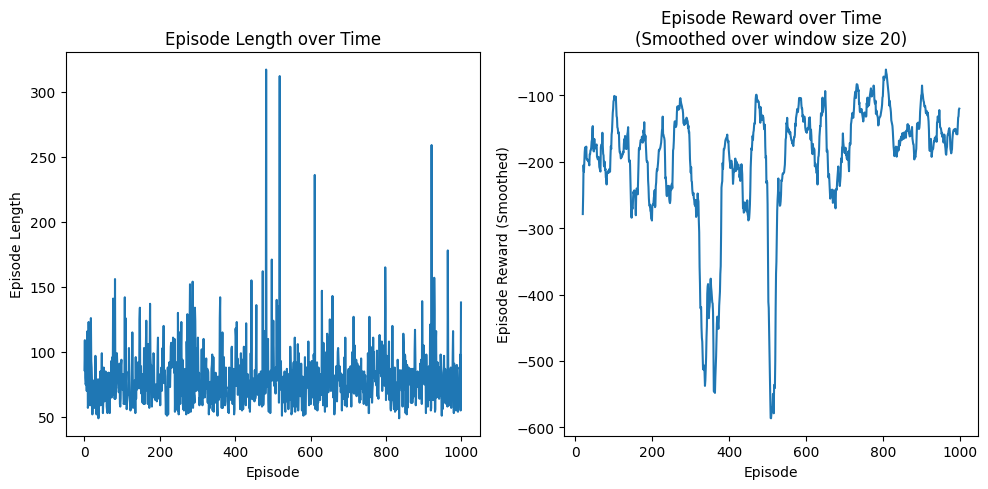

In [56]:
smoothing_window=20
fig, axes = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)

# Plot the episode length over time
ax = axes[0]
ax.plot(stats.episode_lengths)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
ax.plot(rewards_smoothed)
ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")
plt.show()

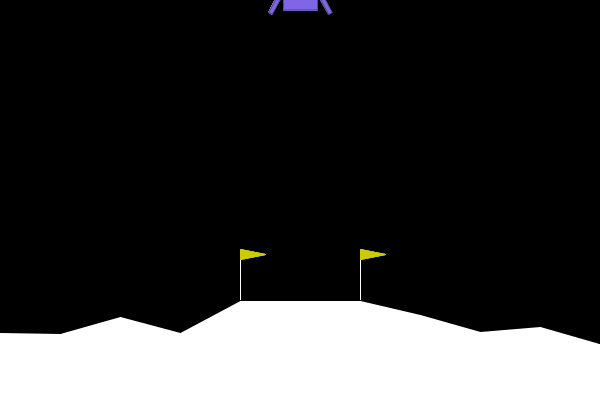

In [57]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array).astype(np.uint8)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        with torch.no_grad():
            action = policy(torch.as_tensor(obs, dtype=torch.float32)).cpu().numpy()

        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

imgs = rendered_rollout(loaded_actor, env)
save_rgb_animation(imgs, "resources/trained.gif")
IImage(filename="resources/trained.gif")